In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

### Reads the data into a dataframe and renames the columns to remove unnecessary numbers 

In [4]:
data_df = pd.read_excel("RNASeqData.xlsx")

In [5]:
data_df = data_df.rename(columns=lambda x: re.sub("w_[0-9]+_O", "w_O",x))
data_df = data_df.rename(columns=lambda x: re.sub("m_[0-9]+_O", "m_O",x))

In [6]:
columns = list(data_df.columns) 

In [7]:
norm_cols = [x for x in columns if "Norm" in x] # get all normalized values
healthy_control = [x for x in norm_cols if "HC" in x] # healthy control norm values
norm_cols_base = [x for x in norm_cols if "Base" in x] # cf without treatment
norm_cols_v2 = [x for x in norm_cols if "V2" in x] # cf with treatment



### Remove extra characters so we can keep patient identifiers

In [8]:
df_norm_base = data_df[norm_cols_base]
df_norm_base = df_norm_base.rename(columns=lambda x: re.sub("Norm_Orkambi_0", "",x))
df_norm_base = df_norm_base.rename(columns=lambda x: re.sub("_Base", "",x))
df_norm_base = df_norm_base.sort_index(axis=1)
df_norm_base = df_norm_base.drop(columns=['02'])

df_norm_v2 = data_df[norm_cols_v2]
df_norm_v2 = df_norm_v2.rename(columns=lambda x: re.sub("Norm_Orkambi_0", "",x))
df_norm_v2 = df_norm_v2.rename(columns=lambda x: re.sub("_V2", "",x))
df_norm_v2 = df_norm_v2.sort_index(axis=1)
df_norm_v2 = df_norm_v2.drop(columns=['19'])

### Function: get_mean_diff
The function takes to lists and simply subtracts the corresponding values and finally takes the average of the differences.

Making a function call can take extra time, so for simple operations like these, it may be helpful when used in conjunction with the **map()** function.

In [9]:
from statistics import mean
def get_mean_diff(base, v2):
  diff = [base[i] - v2[i] for i in range(len(base))] 
  mean_diff = mean(diff)
  # mean of the vector 
  return mean_diff

### Function: get_avg_diff_count

In [60]:
import random
from random import randrange
from random import shuffle
def get_avg_diff_count(expvalues):
    num_shuffles=100000
    base_copy = expvalues[0]
    v2_copy = expvalues[1]
    n_samples = len(base_copy)
    #observed_avg_diff = get_mean_diff(base_copy, v2_copy)
    obsdiff = [base_copy[i] - v2_copy[i] for i in range(n_samples)]
    observed_avg_diff = mean(obsdiff)
    count = 0
    #avg_diffs = []
    # try looping over shuffles
    randomorder = np.array(random.choices([1,-1], k=n_samples*num_shuffles))
    randomshape = (num_shuffles, n_samples)
    randomorder = randomorder.reshape(randomshape)
    randomdiff = np.multiply(randomorder, obsdiff)
    avg_diffs = np.average(randomdiff, axis=1)

    count=[]
    count = np.count_nonzero(abs(avg_diffs) > abs(observed_avg_diff))
    
#    return count/num_shuffles, np.asarray(avg_diffs)
    return count/num_shuffles


### Function: avg_diff_sig_test

In [61]:
def avg_diff_sig_test(df_norm_base, df_norm_v2):
    fullzip = list(zip(df_norm_base.values, df_norm_v2.values))
    all_p_sig_values = [get_avg_diff_count(fullzip[i]) for i in range(len(fullzip))]
    #all_p_sig_values = map(get_avg_diff_count, fullzip)
    return list(all_p_sig_values)

In [62]:
df_norm_v2.shape

(15570, 19)

In [63]:
norm_p_values = avg_diff_sig_test(df_norm_base, df_norm_v2)

In [64]:
norm_p_values[0:5]

[0.28026, 0.28929, 0.0096, 0.6487, 0.10179]

In [66]:
import pickle
pickle.dump( norm_p_values, open( "norm_p_values.p", "wb" ) )

**Bonferroni correction**

In this method, we divide the threshold by the number of genes. So, if we take a default threshold of 5% (or 0.05), now our threshold would be `0.05/len(norm_p_values)`

In [67]:
import pickle
norm_p_values = pickle.load( open( "norm_p_values.p", "rb" ) )
count_significant_genes_bonferroni = 0
for i, ele in enumerate(norm_p_values):
  if ele < (0.05/len(norm_p_values)):
    count_significant_genes_bonferroni += 1
    print(i+1)
print("Number of significant genes: ", count_significant_genes_bonferroni)

Number of significant genes:  0


**Benjamini–Hochberg procedure**

 Put the individual P values in order, from smallest to largest. The smallest P value has a rank of i=1, then next smallest has i=2, etc. Compare each individual P value to its Benjamini-Hochberg critical value, (i/m)Q, where i is the rank, m is the total number of tests, and Q is the false discovery rate you choose. The largest P value that has P<(i/m)Q is significant, and all of the P values smaller than it are also significant, even the ones that aren't less than their Benjamini-Hochberg critical value.

In [68]:
def benjamin_hochberg_corrected_p_values(p_values, fdr):
  num_genes = len(p_values)
  import numpy as np
  sorted_indices = np.argsort(p_values)
  sorted_p_values = sorted(p_values)
  benjamini_hochberg_critical_values = [((i+1)/num_genes)*fdr for i in range(num_genes)]
  for i, p_value in reversed(list(enumerate(sorted_p_values))):
    if p_value < benjamini_hochberg_critical_values[i]:
      break
  return i, sorted_indices

In [143]:
import pickle
norm_p_values = pickle.load( open( "norm_p_values.p", "rb" ) )
i, sorted_indices = benjamin_hochberg_corrected_p_values(norm_p_values, 0.25)
print("Number of significant genes: ", i+1)

Number of significant genes:  1


In [144]:
data_df.loc[6444][14:20]

post_drug.vs.pre_drug_MLELog2FC       -1.65495
post_drug.vs.pre_drug_pVal         4.40299e-06
post_drug.vs.pre_drug_pAdj           0.0356456
control_Mean                             20.23
pre-drug_Mean                            55.86
post-drug_Mean                           17.08
Name: 6444, dtype: object

In [145]:
norm_p_values[6444]

0.08923

In [146]:
df_norm_v2.loc[6444]

01    26.220131
04    38.436591
06    10.362710
07    11.041510
09     5.162527
10    10.750095
12    18.467806
13    11.509118
14    18.359318
15     7.410397
16     5.962505
17    10.882621
18    67.777682
20     3.313864
21    12.973341
22    12.691223
24    32.851086
25    13.435806
26    11.839753
Name: 6444, dtype: float64

In [119]:
df_norm_base.loc[6444]

01      6.437689
04     35.964963
06     64.415597
07     14.532351
09     19.714927
10     13.925694
12     34.883549
13     24.114367
14     27.847446
15     29.548117
16     94.710858
17     18.286489
18      5.678884
20     17.214459
21     10.864266
22     15.517023
24     47.494550
25     20.203974
26    578.546142
Name: 6444, dtype: float64

In [120]:
df_norm_base.loc[6659]

01     199.568365
04      34.526364
06      43.857428
07      93.901346
09      51.399631
10      33.943880
12     233.451446
13      88.110189
14      60.758065
15      30.346715
16      60.133878
17     100.575692
18     123.312905
20      88.720672
21      49.383029
22    6757.663691
24    3159.153584
25      34.258913
26     124.089284
Name: 6659, dtype: float64

In [121]:
df_norm_v2.loc[6659]

01    541.088158
04    183.312973
06     71.387559
07     41.011322
09     79.650415
10     19.019399
12     25.854928
13    247.969171
14    134.635000
15     59.283179
16     68.142914
17    133.700773
18     28.953573
20     85.055835
21    140.710850
22     21.649733
24     55.664341
25     49.609130
26    159.298501
Name: 6659, dtype: float64

In [70]:
significant_genes = []
for i in range(16):
  significant_genes.append((sorted_indices[i]+1))


significant_genes

[188,
 1095,
 10516,
 13503,
 5750,
 11160,
 10363,
 361,
 1549,
 3290,
 15332,
 1392,
 7204,
 7868,
 10593,
 8384]

In [71]:
print(data_df.loc[data_df['RowID'].isin(significant_genes)][['RowID', 'ID', 'Description']])

       RowID            ID                                        Description
187      188        ADAM22                    ADAM metallopeptidase domain 22
360      361         AKIP1                     A-kinase interacting protein 1
1094    1095          BCO2                          beta-carotene oxygenase 2
1391    1392      C1orf115                chromosome 1 open reading frame 115
1548    1549      CACNA2D2  calcium voltage-gated channel auxiliary subuni...
3289    3290       EEF1DP3  eukaryotic translation elongation factor 1 del...
5749    5750         KITLG                                         KIT ligand
7203    7204  LOC105378698                                                NaN
7867    7868        LRRC8D   leucine-rich repeat containing 8 family member D
8383    8384       MIR3939                                      microRNA 3939
10362  10363         PRDX1                                    peroxiredoxin 1
10515  10516         PSMD1               proteasome 26S subunit,

In [72]:
data_df[norm_cols_v2].sum(axis=0)

Norm_Orkambi_007_V2    2.201250e+07
Norm_Orkambi_009_V2    2.599588e+07
Norm_Orkambi_010_V2    2.801257e+07
Norm_Orkambi_012_V2    2.576081e+07
Norm_Orkambi_013_V2    2.615355e+07
Norm_Orkambi_014_V2    2.786734e+07
Norm_Orkambi_001_V2    3.455492e+07
Norm_Orkambi_004_V2    3.376038e+07
Norm_Orkambi_006_V2    2.666307e+07
Norm_Orkambi_015_V2    2.896782e+07
Norm_Orkambi_016_V2    2.332386e+07
Norm_Orkambi_017_V2    2.449434e+07
Norm_Orkambi_018_V2    2.312316e+07
Norm_Orkambi_019_V2    2.542411e+07
Norm_Orkambi_020_V2    2.495638e+07
Norm_Orkambi_021_V2    2.707834e+07
Norm_Orkambi_022_V2    2.569940e+07
Norm_Orkambi_024_V2    2.229553e+07
Norm_Orkambi_025_V2    3.108347e+07
Norm_Orkambi_026_V2    2.474027e+07
dtype: float64

In [130]:
#draw histogram

def draw_hist(d, observed):
    print(observed)
    hist,bin_edges = np.histogram(d,bins =100)    
    plt.figure(figsize=[8,8])
    plt.bar(bin_edges[:-1], hist, width = 0.01, color='#0504aa',alpha=0.7)
    #plt.xlim(min(min(bin_edges),-4), max(max(bin_edges),4))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Normal Distribution Histogram',fontsize=15)
    plt.axvline(x=observed, color='r', linestyle='dashed', linewidth=2)
    plt.show()

0.05


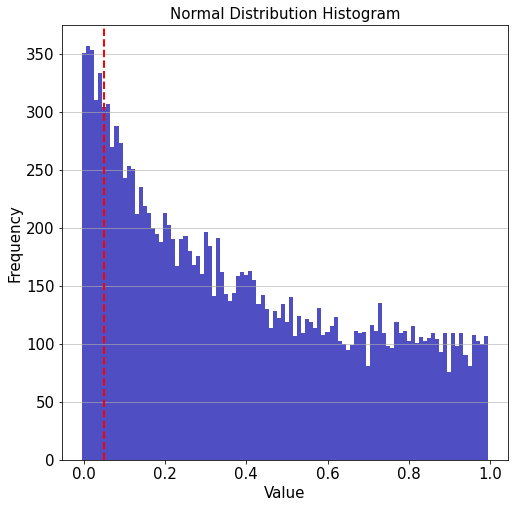

In [131]:
draw_hist(norm_p_values, 0.05)

In [136]:
tmp_sorted_indices = np.argsort(norm_p_values)

In [137]:
tmp_sorted_indices[:5]

array([  187,  1094, 10515, 13502,  5749])

In [138]:
tmp_sorted_p_values = sorted(norm_p_values)

In [139]:
tmp_sorted_p_values[:10]

[1e-05,
 0.00017,
 0.00022,
 0.00026,
 0.00026,
 0.00029,
 0.00029,
 0.00031,
 0.00033,
 0.00038]

In [78]:
tmp_critical_values = [((i+1)/15000)*0.1 for i in range(15000)]

In [79]:
tmp_critical_values[:10]

[6.6666666666666675e-06,
 1.3333333333333335e-05,
 2e-05,
 2.666666666666667e-05,
 3.3333333333333335e-05,
 4e-05,
 4.666666666666667e-05,
 5.333333333333334e-05,
 5.9999999999999995e-05,
 6.666666666666667e-05]

### Akternative method
story 
https://puolival.github.io/multipy/


In [80]:
#from multipy.fwer import sidak

#sidak_pvals = sidak(norm_p_values, alpha=.10)
#print(sidak_pvals)

In [81]:
#from multipy.fdr import qvalue
#_, qvals = qvalue(norm_p_values, threshold=0.10)
#len(qvals)

In [82]:
#sum(qvals<0.05)

In [83]:
#tmp_sorted_qvals = sorted(qvals)
#tmp_sorted_qvals[:10]

In [84]:
import statsmodels.stats.multitest as ssm
norm_p_values_np = np.array(norm_p_values, float)

rej, s_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="s")[:2]
rej, fdr_adjpval = ssm.multipletests(norm_p_values_np, alpha=0.05, method="fdr_i")[:2]

In [85]:
tmp_sorted_s_adjpval = sorted(s_adjpval)
tmp_sorted_s_adjpval[:10]

[0.14418476962410787,
 0.9291453732841632,
 0.967475995077026,
 0.9825554213421549,
 0.9825554213421549,
 0.9890668393337582,
 0.9890668393337582,
 0.9919930734499568,
 0.9941361445966126,
 0.9973086825283916]

In [86]:
tmp_sorted_fdr_adjpval = sorted(fdr_adjpval)
tmp_sorted_fdr_adjpval[:10]

[0.1557,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507,
 0.4235855895196507]

In [87]:
pd.DataFrame([tmp_sorted_p_values[:10],tmp_sorted_fdr_adjpval[:10],tmp_sorted_s_adjpval[:10]])

,0,1,2,3,4,5,6,7,8,9
0,0.000010,0.000170,0.000220,0.000260,0.000260,0.000290,0.000290,0.000310,0.000330,0.000380
1,0.155700,0.423586,0.423586,0.423586,0.423586,0.423586,0.423586,0.423586,0.423586,0.423586
2,0.144185,0.929145,0.967476,0.982555,0.982555,0.989067,0.989067,0.991993,0.994136,0.997309


In [47]:
another_qvalue = estimate(norm_p_values_np, pi0=0.5)

In [48]:
tmp_sorted_another_qvalue = sorted(another_qvalue)
tmp_sorted_another_qvalue[:10]

[0.085635,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168,
 0.10628096793349168]

In [52]:
sum(np.array(tmp_sorted_another_qvalue)<0.1)

1

In [23]:
# slightly modified code from 
# https://github.com/nfusi/qvalue/blob/master/qvalue/qvalue.py
# changes appear to be transition from python2 to python3

import scipy as sp
def estimate(pv, m=None, verbose=False, lowmem=False, pi0=None):
    """
    Estimates q-values from p-values

    Args
    =====

    m: number of tests. If not specified m = pv.size
    verbose: print verbose messages? (default False)
    lowmem: use memory-efficient in-place algorithm
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
         For most GWAS this is not necessary, since pi0 is extremely likely to be
         1

    """
    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    if m is None:
        m = float(len(pv))
    else:
        # the user has supplied an m
        m *= 1.0

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = np.arange(0, 0.90, 0.01)
        counts = np.array([(pv > i).sum() for i in np.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = np.array(pi0)

        # fit natural cubic spline
        tck = sp.interpolate.splrep(lam, pi0, k=3)
        pi0 = sp.interpolate.splev(lam[-1], tck)
        if verbose:
            print("qvalues pi0=%.3f, estimated proportion of null features " % pi0)

        if pi0 > 1:
            if verbose:
                print("got pi0 > 1 (%.3f) while estimating qvalues, setting it to 1" % pi0)
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    if lowmem:
        # low memory version, only uses 1 pv and 1 qv matrices
        qv = np.zeros((len(pv),))
        last_pv = pv.argmax()
        qv[last_pv] = (pi0*pv[last_pv]*m)/float(m)
        pv[last_pv] = -np.inf
        prev_qv = last_pv
        for i in range(int(len(pv))-2, -1, -1):
            cur_max = pv.argmax()
            qv_i = (pi0*m*pv[cur_max]/float(i+1))
            pv[cur_max] = -np.inf
            qv_i1 = prev_qv
            qv[cur_max] = min(qv_i, qv_i1)
            prev_qv = qv[cur_max]

    else:
        p_ordered = np.argsort(pv)
        pv = pv[p_ordered]
        qv = pi0 * m/len(pv) * pv
        qv[-1] = min(qv[-1], 1.0)

        for i in range(len(pv)-2, -1, -1):
            qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

        # reorder qvalues
        qv_temp = qv.copy()
        qv = np.zeros_like(qv)
        qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv


In [27]:
len(norm_p_values_np)

15570

In [36]:
np.array(tmp_sorted_another_qvalue)

array([0., 0., 0., ..., 0., 0., 0.])

In [46]:
max(norm_p_values_np)

0.500277

# Healthy control vs CF